In [1]:
#On importe tous les modules nécessaires
import random,time,pygame,math,numpy,sys,tkinter as tk, screeninfo,os, matplotlib.pyplot as plt
from pygame.locals import *

pygame 2.1.2 (SDL 2.0.18, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def fenetre_generation(fichier_parametres : str) -> None:
    """Lance la fenetre pour modifier les parametres aleatoires"""
    
    def avoirInput() -> None:
        """Recupere les donnees des sliders"""
            
        parametres=open(fichier_parametres,'w+')
        parametres.write(str([variables[i].get() for i in range(17)])[1:-1])
        parametres.close
        frame.after(10,fermer)

    def fermer() -> None:
        """Ferme la fenêtre tkinter et debloque pygame"""
        bloquer_inputs=False
        frame.destroy()
        
    
    #Lire les parametres precedants
    array_parametres=[]
    parametres_open=open(fichier_parametres,'r')
    parametres=parametres_open.readline()
    parametres_open.close
    arr = parametres.split(",")
    array_parametres+=[int(num) for num in arr]
    
    
    #Bloquer pygame et ouvrir la fenetre
    bloquer_inputs=True
    frame=tk.Tk()
    frame.title("Parametres de generation aleatoire")
    frame.geometry('%dx%d+%d+%d' % (window_width, window_height, screen_width/2-window_width/2, screen_height/2-window_height/2))
    
    
    #Textes des sliders
    labels_plantes={"Moyenne des ages" : ("Min","Max"),
                    "Distribution des ages" : ("0","Aleatoire"), 
                    "Espacement minimum" : ("0","100"), 
                    "Densite" : ("0%","100%"), 
                    "Taille X" : ("0","800"), 
                    "Taille Y" : ("0","800"), 
                    "% d'arbres" : ("0%","100%"), 
                    "% de fleurs" : ("0%","100%"), 
                    "% de buissons" : ("0%","100%"), 
                    "% de roches" : ("0%","100%")}
    
    labels_sols={"Taille X" : ("0",str(NB_SOLS)), 
                 "Taille Y" : ("0",str(NB_SOLS)), 
                 "% d'herbe" : ("0%","100%"), 
                 "% de terre" : ("0%","100%"), 
                 "% de beton" : ("0%","100%"), 
                 "% de sable" : ("0%","100%"), 
                 "% d'eau" : ("0%","100%")}
    
    
    
    #Creation des sliders
    variables=[tk.IntVar() for i in range(17)]
    for i in range(10):
        slider=tk.Scale(frame,showvalue=0,from_=0,to=100,orient="horizontal", variable=variables[i], label=list(labels_plantes.keys())[i], length=200)
        slider.place(x=50,y=40+45*i)
        slider.set(array_parametres[i])
        for n,l in enumerate((labels_plantes[list(labels_plantes.keys())[i]])):
            lbl = tk.Label(frame,text=l)
            lbl.pack()
            lbl.place(x=20+232*n,y=60+45*i)
    
    for j in range(7):
        slider=tk.Scale(frame,showvalue=0,from_=0,to=100,orient="horizontal", variable=variables[j+10], label=list(labels_sols.keys())[j], length=200)
        slider.place(x=640,y=40+45*j)
        slider.set(array_parametres[j+10])
        for n,l in enumerate((labels_sols[list(labels_sols.keys())[j]])):
            lbl = tk.Label(frame,text=l)
            lbl.pack()
            lbl.place(x=610+232*n,y=60+45*j)
    
    
    #Bouton pour sauvegarder les donnees des sliders
    soumettreButton = tk.Button(frame,text="Sauvegarder parametres",command=avoirInput)
    soumettreButton.pack()
    soumettreButton.place(x=window_width//2-60,y=window_height*0.85)
    
    
    #Explications avec texte
    label_plantes = tk.Label(frame,text="Parametres vegetation")
    label_plantes.pack()
    label_plantes.place(x=70,y=0)
            
    label_sols = tk.Label(frame,text="Parametres sols")
    label_sols.pack()
    label_sols.place(x=700,y=0)


    #Laisser la fenetre tourner
    frame.mainloop()

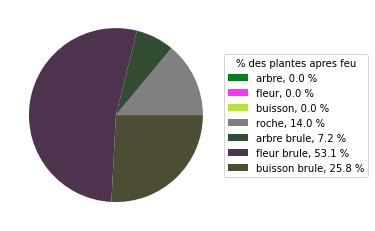

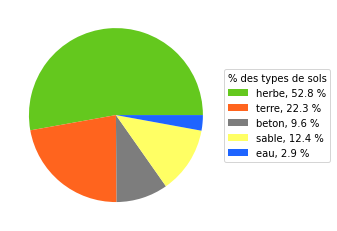

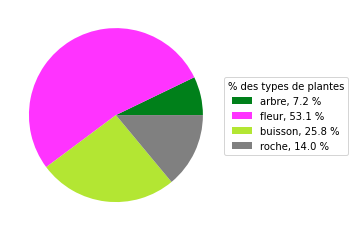

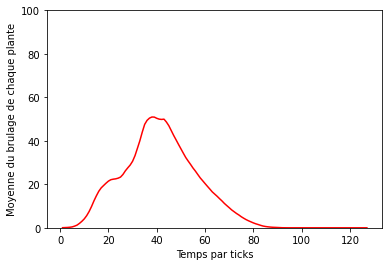

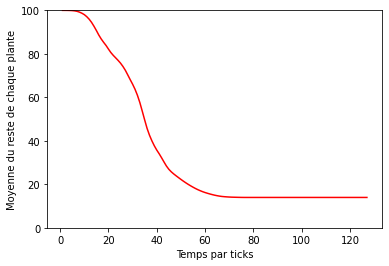

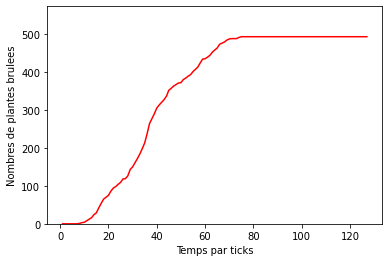

In [16]:
#Constantes utilisees
TAILLE_PLATEAU=800
TAILLE_CHUNK=100
TAILLE_SOLS=20
DECALAGE_ROSE_VENTS_X=110
DECALAGE_ROSE_VENTS_Y=-150
RAYON_CERCLE_VENT=60
COLOR_FONT=[150,50,0]
NB_CHUNKS=TAILLE_PLATEAU//TAILLE_CHUNK
NB_SOLS=TAILLE_PLATEAU//TAILLE_SOLS
TAILLE_BOUTON=50
ESPACEMENT_BOUTON=20
TAILLE_INTERFACE_DROITE=600
TAILLE_FONT=40

#On initialise pygame et la fenetre tkinter
pygame.init()
for monitor in screeninfo.get_monitors():
    screen_width = monitor.width
    screen_height = monitor.height
    window_height=600
    window_width=900
frame=tk.Tk()
frame.geometry('%dx%d+%d+%d' % (window_width, window_height, screen_width/2-window_width/2, screen_height/2-window_height/2))
frame.destroy()
fenetre=pygame.display.set_mode((TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE,TAILLE_PLATEAU))
font=pygame.font.Font("font.ttf",TAILLE_FONT)

def charger_image(nom_image):
    """Charge une image dont le chemin est passe en parametre"""
    image=pygame.image.load(nom_image).convert_alpha()
    return image


def dessiner_objet(objet,nom_objet,opacite):
    
    image=images[objets_total.index(nom_objet)]
    
    image=pygame.transform.scale(image,(objet.diametre,objet.diametre))
    image_rect=image.get_rect()
    image.set_alpha(opacite)
    image_rect=(objet.x-objet.diametre//2,objet.y-objet.diametre//2)
    return image,image_rect

#Initialisation des plateaux
plateau_plantes=[[[] for x in range(NB_CHUNKS)] for y in range(NB_CHUNKS)]
plateau_sols=numpy.zeros((NB_SOLS,NB_SOLS), dtype = int)

#Initialisation des parametres par defaut
total_comparaisons_reussies=0
ticks=0
comparaisons_fin=False
poser=0
autre_point_vent=[0,0]
age=50
surface_brush_sol=1

#Differents etats du programme
bloquer_inputs=False
lancer_feu=False
feu_fini=False
arreter_sim=False

#Classe vegetation pour les objets du plateau
class vegetation :
    
    def __init__(self,diametre,robustesse,x,y,nom,brulage,reste,age):
        self.diametre,self.robustesse,self.x,self.y,self.nom,self.brulage,self.reste,self.age=diametre,robustesse,x,y,nom,brulage,reste,age
        
    def __str__(self):
        return str((self.diametre,self.robustesse,self.x,self.y,self.nom, self.brulage, self.reste,self.age))
    
    def __repr__(self):
        return "vegetation"+str((self.diametre,self.robustesse,self.x,self.y,self.nom, self.brulage, self.reste,self.age))



#Boutons
RECT_BOUTON_PARAMETRES=(TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE*0.75,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*2,TAILLE_BOUTON,TAILLE_BOUTON)
RECT_BOUTON_ALEATOIRE=(TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE*0.75,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*3,TAILLE_BOUTON,TAILLE_BOUTON)
RECT_ICONE_PARAMETRES=(RECT_BOUTON_PARAMETRES[0]+5,RECT_BOUTON_PARAMETRES[1]+5,RECT_BOUTON_PARAMETRES[2]-3,RECT_BOUTON_PARAMETRES[3]-3)
RECT_ICONE_ALEATOIRE=(RECT_BOUTON_ALEATOIRE[0]+6,RECT_BOUTON_ALEATOIRE[1]+6,RECT_BOUTON_ALEATOIRE[2]-3,RECT_BOUTON_ALEATOIRE[3]-3)
RECT_BOUTON_FEU=(TAILLE_PLATEAU+200,600,200,TAILLE_FONT+6)
RECT_BOUTON_ARRET=(TAILLE_PLATEAU,TAILLE_PLATEAU-50,TAILLE_INTERFACE_DROITE,50)
RECT_BOUTON_SAUVEGARDE=(TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE-225,300,200,TAILLE_FONT)
RECT_BOUTON_LOAD=(TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE-225,310+TAILLE_FONT+6,200,TAILLE_FONT)

POINT_VENT=(TAILLE_PLATEAU+RAYON_CERCLE_VENT+DECALAGE_ROSE_VENTS_X,TAILLE_PLATEAU+RAYON_CERCLE_VENT+DECALAGE_ROSE_VENTS_Y)
ROSE_DES_VENTS=charger_image("rose_des_vents.png")
ROSE_DES_VENTS=pygame.transform.scale(ROSE_DES_VENTS,(RAYON_CERCLE_VENT*2,RAYON_CERCLE_VENT*2))
ROSE_DES_VENTS_RECT=ROSE_DES_VENTS.get_rect()
ROSE_DES_VENTS_RECT[0],ROSE_DES_VENTS_RECT[1]=POINT_VENT[0]-RAYON_CERCLE_VENT,POINT_VENT[1]-RAYON_CERCLE_VENT

COULEURS_SOLS={"herbe" : [100,200,30], "terre" : [255,100,30], "beton" : [125,125,125] , "sable" : [255,255,100], "eau" : [30,100,255]}

#Boutons et objets
selectionne="arbre"
objets=["arbre","fleur","buisson","roche"]
objets_brules=[objet + " brule" for objet in objets]
objets_total=objets+objets_brules+["feu","fond","gomme","parametres","aleatoire"]
sols=["herbe","terre","beton","sable","eau"]
sol_selectionne="herbe"

#Age maximum de chaque type d'objet
caracteristiques={"arbre" : { "age_max" : 50}, 
                  "fleur" : { "age_max" : 3}, 
                  "buisson" : { "age_max" : 10} , 
                  "roche" : { "age_max" : 100}
                 }

numeros_plantes=[i for i in range(4)]
numeros_sols=[i for i in range(5)]
images=[charger_image(truc+".png") for truc in objets_total]
images_sols=[pygame.transform.scale(charger_image(sol+".png"),(TAILLE_SOLS,TAILLE_SOLS)) for sol in sols]

def check_click_bouton(rect : tuple) -> bool:
    """Renvoie True ou False selon si l'utilisateur a clique sur un bouton defini par rect(x,y,largeur,hauteur)"""
    click = pygame.mouse.get_pos()
    if 0<=click[0]-rect[0]<=rect[2] and 0<=click[1]-rect[1]<=rect[3]:
        return True
    return False

def dessiner_bouton(rect : tuple, actif : bool):
    """Dessine un bouton comme le rect passe en parametre, dessine les contours en vert si actif est True"""
    if actif:
        pygame.draw.rect(fenetre,[0,255,0],rect)
        pygame.draw.rect(fenetre,[255,255,200],(rect[0]+3,rect[1]+3,rect[2]-6,rect[3]-6))
        return
    
    pygame.draw.rect(fenetre,COLOR_FONT,(rect[0],rect[1],rect[2],rect[3]))
    pygame.draw.rect(fenetre,[255,255,200],(rect[0]+3,rect[1]+3,rect[2]-6,rect[3]-6))

def copie_plante(objet : vegetation) -> vegetation:
    """Renvoie une copie de l'objet de classe vegetation passe en parametres"""
    return vegetation(objet.diametre,objet.robustesse,objet.x,objet.y,objet.nom,objet.brulage,objet.reste,objet.age)   

def copie_plateau(plateau_plantes : list) -> list:
    """Renvoie une copie du plateau d'objets envoye en parametre"""
    nouv_plateau=[[[] for x in range(NB_CHUNKS)] for y in range(NB_CHUNKS)]
    for y in range(NB_CHUNKS):
        for x in range(NB_CHUNKS):
            for objet in plateau_plantes[y][x]:
                nouv_plateau[y][x].append(copie_plante(objet))
    
    return nouv_plateau

def comparer(plateau_1 : list,plateau_2 : list) -> bool:
    """Compare deux plateaux de plantes passes en parametres"""
    for y in range(NB_CHUNKS):
        for x in range(NB_CHUNKS):
            for (objet_avant,objet_apres) in zip(plateau_1[y][x],plateau_2[y][x]):
                if objet_avant.reste!=objet_apres.reste:
                    return False
    return True
                

def taille_robustesse(objet : str, age : int) -> tuple:
    """Renvoie la taille et la robustesse d'une plante en fonction de son age"""
    return [[int(math.log(30*age+50)**2), int(math.log(25*age+60)**1.5)], #Arbre
            [3*math.sqrt(age)+10, 3], #Fleur
            [int(math.log(2+30*age**3)+15), age+20], #Buisson
            [age+3, 999 ]  #Roche
           ][objets.index(objet)]
    
def distance(x1 : int,y1 : int,d1 : int,x2 : int,y2 : int,d2 : int) -> float:
    """Distance entre 2 cercles"""
    return math.sqrt((x1-x2)**2+(y1-y2)**2)-(d1/2+d2/2)


def distance_chunks(coors : tuple,plateau_plantes : list,diametre : int):
    """Fonction pour calculer les distance entre des coordonnees (x,y) et chaque objet d'un plateau de vegetations"""
    
    chunk_x=coors[0]//TAILLE_CHUNK
    chunk_y=coors[1]//TAILLE_CHUNK
    distances=[]
    
    for y in range(-1,2):
        for x in range(-1,2):
            chunk_y_check,chunk_x_check=chunk_y+y,chunk_x+x
            if 0<=chunk_x_check<NB_CHUNKS and 0<=chunk_y_check<NB_CHUNKS:
                for objet in plateau_plantes[chunk_y_check][chunk_x_check]:
                    distances.append(distance(objet.x,objet.y,objet.diametre,coors[0],coors[1],diametre))
                    
    return distances

def force_vec(pt : tuple) -> int:
    """retourne la norme d'un vecteur"""
    return int(math.sqrt(pt[0]**2+pt[1]**2))

def angle_vec(pt : tuple) -> int:
    """retourne l'angle d'un vecteur"""
    if pt==[0,0]:
        return 0
    return (int(numpy.angle(pt[0]+pt[1]*1j, deg=True))+470)%360
                 
def render_sols(plateau_sols : list) -> None:
    """Affiche le plateau de sol"""
            
    for x,ligne in enumerate(plateau_sols):
        for y,colonne in enumerate(ligne):
            for i in range(0,9,3):
                
                carre_fondu=pygame.Surface((TAILLE_SOLS+i,TAILLE_SOLS+i))
                carre_fondu.fill(COULEURS_SOLS[sols[colonne]])
                carre_fondu.set_alpha(70-5*i)
                fenetre.blit(carre_fondu,(x*TAILLE_SOLS-(i//2),y*TAILLE_SOLS-(i//2)))
            
def render_plateau(plateau_plantes : list,en_train_bruler : bool) -> None:
    """Affiche le plateau de vegetation en fonction de si la simulation de feu est lancee"""
    if en_train_bruler: #Brule
        for y in range(NB_CHUNKS):
            for x in range(NB_CHUNKS):
                for objet in plateau_plantes[y][x]:

                    objet_brule=dessiner_objet(objet, objet.nom+" brule",255)[0]
                    image_feu=dessiner_objet(objet, "feu",int(objet.brulage*2.5))[0]
                    objet,objet_rect=dessiner_objet(objet, objet.nom, int(objet.reste*2.5))

                    fenetre.blit(objet_brule,objet_rect)
                    fenetre.blit(objet,objet_rect)
                    fenetre.blit(image_feu,objet_rect)

    else: #Ne brule pas
        for y in range(NB_CHUNKS):
            for x in range(NB_CHUNKS):
                for objet in plateau_plantes[y][x]:
                    image,image_rect=dessiner_objet(objet, objet.nom, 255)
                    fenetre.blit(image,image_rect)

                    
def ajout_plante(coors : tuple,plateau_plantes : list,age : int,nom : str) -> None:
    """Ajoute une plante sur le plateau s'il y a la place"""
    chunk_x=coors[0]//TAILLE_CHUNK
    chunk_y=coors[1]//TAILLE_CHUNK
    diametre_plante,robustesse_plante=taille_robustesse(nom,age)
    
    distances=distance_chunks((coors[0],coors[1]),plateau_plantes,diametre_plante)
    if distances==[] or min(distances)>=0:
        plateau_plantes[chunk_y][chunk_x].append(vegetation(diametre_plante,robustesse_plante,coors[0],coors[1],nom,0,100,age))


def generer_aleatoirement(coors,fichier_parametres):
    """Genere un plateau aleatoire en fonctions des parametres sauvegardes"""
    
    #Lecture des parametres
    array_parametres=[]
    parametres_open=open(fichier_parametres,'r')
    parametres=parametres_open.readline()
    arr = parametres.split(",")
    array_parametres+=[int(num) for num in arr]
    
    #Initialisation de la generation
    rayon_x_sol=array_parametres[10]//5
    rayon_y_sol=array_parametres[11]//5
    case_sol_x=(coors[0]//TAILLE_SOLS)
    case_sol_y=(coors[1]//TAILLE_SOLS)
    proba_totale_sols=numpy.sum(array_parametres[12:17])
    probas_sols=[array_parametres[i]/proba_totale_sols for i in range(12,17)]
    
    
    #Generation du sol
    for x in range(case_sol_x-rayon_x_sol,case_sol_x+rayon_x_sol+1):
        for y in range(case_sol_y-rayon_y_sol,case_sol_y+rayon_y_sol+1):
            if 0<=x<NB_SOLS and 0<=y<NB_SOLS:
                plateau_sols[x][y]=numpy.random.choice(numeros_sols,1,p=probas_sols)[0]
     
    
    #Generation des plantes
    rayon_x_plante=array_parametres[4]*4
    rayon_y_plante=array_parametres[5]*4
    proba_totale_plantes=numpy.sum(array_parametres[6:10])
    probas_plantes=[array_parametres[i]/proba_totale_plantes for i in range(6,10)]
    espacement=array_parametres[2]
    densite=array_parametres[3]
    
    for x in range(-rayon_x_plante,rayon_x_plante,10+espacement+(100-densite)):
        for y in range(-rayon_x_plante,rayon_x_plante,10+espacement+(100-densite)):
            decalage=numpy.random.randint(-3,3)
            if 0<=coors[0]+x+decalage<TAILLE_PLATEAU and 0<=coors[1]+y+decalage<TAILLE_PLATEAU:
                if numpy.random.randint(0,100)<densite:
                    chunk_x=(coors[0]+x+decalage)//TAILLE_CHUNK
                    chunk_y=(coors[1]+y+decalage)//TAILLE_CHUNK
                    if 0<=chunk_x<NB_CHUNKS and 0<=chunk_y<NB_CHUNKS:
                        type_plante=objets[numpy.random.choice(numeros_plantes,1,p=probas_plantes)[0]]
                        age_plante=abs(numpy.random.normal(array_parametres[0],array_parametres[1],1)[0])*caracteristiques[type_plante]["age_max"]/100
                        age_plante=min(caracteristiques[type_plante]["age_max"],age_plante)
                        diametre_plante,robustesse_plante=taille_robustesse(type_plante,age_plante)

                        distances=distance_chunks((coors[0]+x+decalage,coors[1]+y+decalage),plateau_plantes,diametre_plante)
                        if distances==[] or min(distances)>=espacement:
                            plateau_plantes[chunk_y][chunk_x].append(vegetation(diametre_plante,robustesse_plante,coors[0]+x+decalage,coors[1]+y+decalage,type_plante,0,100,age))


    parametres_open.close
    
def retourner_objet_clique(plateau_plante,coors):
    """Retourne l'objet clique au coordonnees coors s'il existe"""
    chunk_x=coors[0]//TAILLE_CHUNK
    chunk_y=coors[1]//TAILLE_CHUNK
    for x in range(-1,1):
        for y in range(-1,1):
            if 0<=chunk_x+x<NB_CHUNKS and 0<=chunk_y+y<NB_CHUNKS:
                for i,objet in enumerate(plateau_plante[chunk_y+y][chunk_x+x]):
                    if distance(coors[0],coors[1],0,objet.x-objet.diametre/2,objet.y-objet.diametre/2,0)<=objet.diametre:
                        return (chunk_y+y,chunk_x+x,i)
    
    return (-1,-1,-1) #Cas ou rien n'est touche
    
    
def sauvegarder(plateau_plantes,plateau_sols,fichier_sauvegarde):
    """Fonction pour sauvegarder le plateau"""
    sauvegarde=open(fichier_sauvegarde,'w')
    plateau_sols_str=str([[plateau_sols[y][x] for x in range(NB_SOLS)] for y in range(NB_SOLS)])

    sauvegarde.write("plateau_plantes="+str(plateau_plantes)+f"\n")
    sauvegarde.write("plateau_sols=numpy.asarray("+plateau_sols_str+f")\n")
    
def charger(fichier_sauvegarde):
    """Fonction pour charger un plateau sauvegarde"""
    chargement=open(fichier_sauvegarde,'r')
    lines=chargement.readlines()
    exec(lines[0],globals())
    exec(lines[1],globals())
                    
def render_boutons_icones(boutons_liste,poser,objets,boutons_objets_icones):
    """Dessine les boutons pour les objets et sols"""
    for i,bouton in enumerate(boutons_liste):
        dessiner_bouton(bouton,False)
        image_bouton=charger_image(objets[i]+".png")
        image_bouton=pygame.transform.scale(image_bouton,(int(TAILLE_BOUTON*0.8),int(TAILLE_BOUTON*0.8)))
        
        #Dessiner un carre vert autour de l'objet selectionne
        if objets[i]==selectionne and poser==0: #Vegetation
            dessiner_bouton(bouton,True)
            
        elif objets[i]==sol_selectionne and poser==1: #Sols
            dessiner_bouton(bouton,True)
            
        elif poser==2: #Aleatoire
            dessiner_bouton(RECT_BOUTON_ALEATOIRE,True)

        elif poser==3 and objets[i]=="gomme": #Supprimer
            dessiner_bouton(bouton,True)
            
        
        fenetre.blit(image_bouton,boutons_objets_icones[i])

        
#CODE DE PROPAGATION

        
##vents
CCDV = 0.3 #chance de changement de direction du vent (%)
CAV = 5 #changement de direction du vent (angle)
CCVV = 0.5 #chance de changement de vitesse du vent (%)
CVV = 1 #changement de vitesse du vent (m/s)
VMAX=50 #vitesse du vent maximum
dire=0
v=1

def vent(dire : int,vitesse : int) -> (int,int):
    """Met à jour la vitesse et la force du vent aleatoirement"""
    if (random.random()<CCDV):
        dire +=random.randint(-CAV,CAV)
    if (random.random()<CCVV):
        vitesse+=random.randint(-CVV,CVV)
  
      #modif direction
    if dire>360:
        dire-=360
    if dire<0:
        dire+=360
      #modif vitesse
    if (vitesse>VMAX):
        vitesse=VMAX
    if (vitesse<1):
        vitesse=1

    return dire,vitesse


def in_range(entity1 : vegetation,entity2 : vegetation, lenv : float) -> bool:
    """Retourne si une plante est dans une certaine zone par rapport a une autre"""
     #sol:e, vent: ",c," area: ",z)
    moy_sols=test_sol(entity1)
    propag=3<moy_sols
    #cone de propagation
    vent = 0>distance(entity1.x+lenv*math.cos(math.radians(dire)),entity1.y+lenv*math.sin(math.radians(dire)),lenv*entity1.brulage/70,entity2.x,entity2.y,entity2.diametre) 
    #zone autour de l'arbre
    aire= entity1.diametre*entity1.brulage/20
    contenu_dans_aire=0>distance(entity1.x,entity1.y,aire,entity2.x,entity2.y,entity2.diametre)
    return ((propag and (contenu_dans_aire or vent)) or 0>distance(entity1.x,entity1.y,aire/4,entity2.x,entity2.y,entity2.diametre)), moy_sols


def test_sol(entity : vegetation) -> float:
    """Retourne la moyenne des combustibilites des sols sur lesquels est la plante"""
    r=math.floor((entity.diametre/TAILLE_SOLS)/2)
    c=0
    t=0
    for x in range((int(entity.x//TAILLE_SOLS)-r),int(entity.x//TAILLE_SOLS+r)+1):
        for y in range((int(entity.y//TAILLE_SOLS)-r),int(entity.y//TAILLE_SOLS+r)+1):
            if y<40 and x<40:
                if plateau_sols[y][x]==0: #Herbe
                    c+=6

                elif plateau_sols[y][x]==1: #Terre
                    c+=4.5
                    
                elif plateau_sols[y][x]==2: #Beton
                    c+=2.5

                elif plateau_sols[y][x]==3: #Sable
                    c+=2.1

                elif plateau_sols[y][x]==4: #Eau
                    c-=2
                
                t+=1

        return c+1/t
    

def check_propa()->None:
    for i in range(NB_CHUNKS):
        for j in range(NB_CHUNKS):
            for k in plateau_plantes[i][j]:
                if k.brulage>10:
                    lenV=(math.log2(v)+k.diametre/2)*k.brulage/50
                    for a in range(-1,2):
                        for b in range(-1,2):
                            if 0<=a+i<NB_CHUNKS and 0<=b+j<NB_CHUNKS:
                                for c in Nplateau[i+a][j+b]:
                                    if c.reste>10:
                                        t,ca=in_range(k,c,lenV)
                                        if t and random.randint(0,100)*k.brulage*ca/3.5>c.robustesse:
                                            tmp=int(min(10,-(c.brulage-100))*ca/5)
                                            c.brulage+=int(min(10,-(c.brulage-100))*ca/8)

#changement d'etat des objets
def fonction_int(entity)->None:
    if entity.reste < 10 and entity.brulage>0:
        entity.brulage-=random.randint(0,min(entity.brulage,10))
    elif entity.brulage<8 and entity.brulage>0:
        entity.brulage-=1
    else:
        if entity.brulage>5:
            if entity.brulage+5<100:
                entity.brulage+=2
            else:
                entity.brulage-=1
        
def fonction_reste(entity)->None:
    entity.reste-=int(entity.brulage/entity.robustesse)
    if entity.reste<0:
        entity.reste=0

def HP()->None:
 
    for py in range(NB_CHUNKS):
        for px in range(NB_CHUNKS):
            for entity in Nplateau[py][px]:
                if entity.nom=="roche":
                    entity.brulage=0
                else:
                    fonction_int(entity)
                    fonction_reste(entity)

#debuger
def aff():
    if os.name=='nt':
        os.system("cls")
    else:
        os.system("clear")
    for a in plateau_plantes:
        for b in a:
            for c in b:
                print("Nom : ",c.nom," , brulage : ",c.brulage, " , reste : ", c.reste,"\n")
    print("dir = ",dire, " , vit = ",v,"\n")


#logs
log_reste=[]
log_brule=[]
log_v=[]
log_dire=[]
evol_reste=[]
evol_brulage=[]

#update logs
def update_info(dire,v)->None:
    log_dire.append(dire)
    log_v.append(v)
    log_brule.append(pbrule())
    log_reste.append(preste())

def preste() -> (int,int,int):
    "Compte le nombre de plantes brulees"
    comptes=[0,0,0]
    for py in range(NB_CHUNKS):
        for px in range(NB_CHUNKS):
            for entity in plateau_plantes[py][px]:
                if entity.reste<5 and entity.nom!="roche":
                    comptes[objets.index(entity.nom)]+=1
          
    return comptes

def pbrule()-> (int,int,int):
    "Compte le nombre de plantes en feu"
    comptes=[0,0,0]
    for py in range(NB_CHUNKS):
        for px in range(NB_CHUNKS):
            for entity in plateau_plantes[py][px]:
                if entity.brulage>5 and entity.nom!="roche":
                    comptes[objets.index(entity.nom)]+=1
          
    return comptes

def diagramme_sols(plateau_sols : numpy.asarray) -> None:
    """Dessine le diagramme des proportions de chaque type de sol"""
    liste_sols=[0,0,0,0,0]
    for x in range(NB_SOLS):
        for y in range(NB_SOLS):
            liste_sols[plateau_sols[x][y]]+=1
    legend = ['%s, %1.1f %%' % (s,p*100/(NB_SOLS**2)) for s,p in zip(sols,liste_sols)]
    liste_couleurs=list(COULEURS_SOLS.values())
    _ = plt.pie(liste_sols, colors = [[liste_couleurs[i][r]/255 for r in range(3)] for i in range(5)]) 
    plt.legend(legend, title="% des types de sols", bbox_to_anchor=(0.75,0.5), loc="center left", fontsize=10, bbox_transform=plt.gcf().transFigure)
    plt.savefig("Diagramme_sols.png", bbox_inches='tight')
    plt.show()

    
def diagramme_plantes(plateau_plantes : list):
    """Dessine le diagramme des proportions de chaque type de plantes"""
    liste_plantes=[0,0,0,0]
    for x in range(NB_CHUNKS):
        for y in range(NB_CHUNKS):
            for objet in plateau_plantes[y][x]:
                liste_plantes[objets.index(objet.nom)]+=1
    total_plantes=numpy.sum(liste_plantes)
    legend = ['%s, %1.1f %%' % (s,p*100/total_plantes) for s,p in zip(objets,liste_plantes)]
    _ = plt.pie(liste_plantes, colors = ((0,0.5,0.1),(1,0.2,1),(0.7,0.9,0.2),(0.5,0.5,0.5))) 
    plt.legend(legend, title="% des types de plantes", bbox_to_anchor=(0.75,0.5), loc="center left", fontsize=10, bbox_transform=plt.gcf().transFigure)
    plt.savefig("Diagramme_plantes.png", bbox_inches='tight')
    plt.show()
    
def graph_evol(liste : list, label :str):
    """Dessine le graphe de l'evolution d'une liste en fonction du temps"""
    plt.ylim(0,100)
    plt.plot([i for i in range(1, ticks + 1)], liste, color = "red")
    plt.xlabel('Temps par ticks')
    plt.ylabel(label)
    #plt.show()
    plt.savefig("Graphique " + label+".png")
    plt.show()
    
def graph_evol_brules(logs : list, plateau_plantes : list):
    """Dessine le graphe de l'evolution des plantes brulees en fonction du temps"""
    nb_plantes=0
    for x in range(NB_CHUNKS):
        for y in range(NB_CHUNKS):
            nb_plantes+=len(plateau_plantes[x][y])
    plt.ylim(0,nb_plantes)
    liste=[numpy.sum(logs[i]) for i in range(len(logs))]
    plt.plot([i for i in range(1, ticks + 1)], liste , color = "red")
    plt.xlabel('Temps par ticks')
    plt.ylabel("Nombres de plantes brulees")
    plt.savefig("Graphique nombres de plantes brulees.png")
    plt.show()
    
def diagramme_post_feu(log,plateau_plantes):
    """Dessine le diagramme des proportions de chaque type de plantes apres le feu"""
    #On recolte le total de chaque plante
    liste_plantes=[0,0,0,0]
    for x in range(NB_CHUNKS):
        for y in range(NB_CHUNKS):
            for objet in plateau_plantes[y][x]:
                liste_plantes[objets.index(objet.nom)]+=1
       
    #On enleve les brulees
    total_plantes=numpy.sum(liste_plantes)
    objets_brules=[]
    for i in range(3):
        objets_brules.append(objets[i]+" brule")
        liste_plantes[i]-=log[i]
        
    couleurs = ((0,0.5,0.1),(1,0.2,1),(0.7,0.9,0.2),(0.5,0.5,0.5),(0.2,0.3,0.2),(0.3,0.2,0.3),(0.3,0.3,0.2))
    _ = plt.pie(liste_plantes+log, colors = couleurs) 
    legend = ['%s, %1.1f %%' % (s,p*100/total_plantes) for s,p in zip(objets+objets_brules,liste_plantes+log)]
    plt.legend(legend, title="% des plantes apres feu", bbox_to_anchor=(0.75,0.5), loc="center left", fontsize=10, bbox_transform=plt.gcf().transFigure)
    plt.savefig("Diagramme_plantes_brulees.png", bbox_inches='tight')
    plt.show()
    
def afficher_graphiques():
    """Affiche tous les graphiques"""
    for n,d in enumerate(("Diagramme_sols.png","Diagramme_plantes.png","Diagramme_plantes_brulees.png")):
        image=charger_image(d)
        image=pygame.transform.scale(image,(350+2.5*n,240))
        fenetre.blit(image,(TAILLE_INTERFACE_DROITE+180,200*(n+0.6)))
        
    for n,g in enumerate(("Graphique nombres de plantes brulees.png","Graphique Moyenne du reste de chaque plante.png","Graphique Moyenne du brulage de chaque plante.png")):
        image=charger_image(g)
        image=pygame.transform.scale(image,(300,200))
        fenetre.blit(image,(TAILLE_INTERFACE_DROITE+520,200*(n+0.7)))

#Programme pygame principal
try:
    
    
    #Declaration des boutons et texte non dynamiques
    boutons_objets=[(TAILLE_PLATEAU+TAILLE_BOUTON*3,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*(i+1), TAILLE_BOUTON, TAILLE_BOUTON) for i in range(1,len(objets)+2)]
    boutons_objets_icones=[(TAILLE_PLATEAU+TAILLE_BOUTON*3+5,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*(i+1)-5+TAILLE_BOUTON*0.2, TAILLE_BOUTON*0.2, TAILLE_BOUTON*0.2) for i in range(1,len(objets)+2)]
    
    boutons_sols=[(TAILLE_PLATEAU+TAILLE_BOUTON,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*(i+1), TAILLE_BOUTON, TAILLE_BOUTON) for i in range(1,len(sols)+1)]
    boutons_sols_icones=[(TAILLE_PLATEAU+TAILLE_BOUTON+5,(TAILLE_BOUTON+ESPACEMENT_BOUTON)*(i+1)-5+TAILLE_BOUTON*0.2, TAILLE_BOUTON*0.2, TAILLE_BOUTON*0.2) for i in range(1,len(sols)+1)]
    
    image_fond=charger_image("fond.png")
    image_fond=pygame.transform.scale(image_fond,(TAILLE_INTERFACE_DROITE,TAILLE_PLATEAU))
    
    texte_feu=font.render("Lancer feu", True, [255,0,0])
    texte_sauvegarde=font.render("Sauvegarde", True, COLOR_FONT)
    texte_load=font.render("   Charger", True, COLOR_FONT)
    texte_sols=font.render("       Sols   ", True, COLOR_FONT)
    texte_objets=font.render("   & objets", True, COLOR_FONT)
    texte_arreter_sim=font.render("           Arreter la simulation", True, COLOR_FONT)
    texte_merci=font.render("          Merci d'avoir utiliser", True, COLOR_FONT)
    texte_merci_2=font.render("             notre simulation ! ", True, COLOR_FONT)

    continuer=True #méthode pour maintenir la fenêtre ouverte
    pygame.key.set_repeat(0,0) #on laisse l'enfoncée des touches  
    
    while continuer:
          
        for event in pygame.event.get():
            if event.type==QUIT: #moyen de sortir de la boucle
                continuer=False

            elif event.type==MOUSEWHEEL:
                #Pour changer l'age, taille de la surface de sol posee
                if not lancer_feu:
                    if poser==0:
                        age+=event.y
                        age=max(0,age)
                        age=min(age,caracteristiques[selectionne]["age_max"])
                    elif poser==1:
                        surface_brush_sol+=event.y
                        surface_brush_sol=max(1,surface_brush_sol)
                        surface_brush_sol=min(surface_brush_sol,NB_SOLS)
                        

            elif pygame.mouse.get_pressed()[0]:
                
                #Detecte les clicks
                click = pygame.mouse.get_pos()
                
                
                if not lancer_feu: #Si on est encore on mode construction
                    
                    
                    #Si on est sur le plateau
                    if poser==0:
                        bord=taille_robustesse(selectionne,age)[0]
                        rect_plateau=(bord/2,bord/2,TAILLE_PLATEAU-bord,TAILLE_PLATEAU-bord)
                    else:
                        rect_plateau=(0,0,TAILLE_PLATEAU,TAILLE_PLATEAU)
                        
                    if check_click_bouton(rect_plateau):
                        if poser==0:
                            ajout_plante(click,plateau_plantes,age,selectionne)
                        elif poser==1:
                            surface_sols_abs=surface_brush_sol//2
                            for y in range(-surface_sols_abs,surface_sols_abs+1):
                                for x in range(-surface_sols_abs,surface_sols_abs+1):
                                    case_sol_x=(click[0]//TAILLE_SOLS)+x
                                    case_sol_y=(click[1]//TAILLE_SOLS)+y
                                    if 0<=case_sol_x<NB_SOLS and 0<=case_sol_y<NB_SOLS:
                                        plateau_sols[case_sol_x][case_sol_y]=sols.index(sol_selectionne)
                        elif poser==2:
                            generer_aleatoirement(click,"parametres.txt")
                            
                        elif poser==3:
                            (y,x,i)=retourner_objet_clique(plateau_plantes,click)
                            if (y,x,i)!=(-1,-1,-1):
                                plateau_plantes[y][x].pop(i)
                        elif poser==4:
                            (y,x,i)=retourner_objet_clique(plateau_plantes,click)
                            if (y,x,i)!=(-1,-1,-1):
                                plateau_plantes[y][x][i].brulage=20
                                dire=angle_vec(autre_point_vent)
                                v=force_vec(autre_point_vent)
                                liste_ages=[[] for i in range(len(objets))]
                                for y in range(NB_CHUNKS):
                                    for x in range(NB_CHUNKS):
                                        for objet in plateau_plantes[y][x]:
                                            liste_ages[objets.index(objet.nom)].append(objet.age)
                                            
                                lancer_feu=True
                    
                    
                    else: #Si on est sur l'interface a droite
                        
                        #Boutons de sols et plantes
                        for i,bouton in enumerate(boutons_objets):
                            if check_click_bouton(bouton):
                                if i<4:
                                    selectionne=objets[i]
                                    poser=0
                                    age=min(age,caracteristiques[selectionne]["age_max"])
                                
                                else:
                                    poser=3

                        for i,bouton in enumerate(boutons_sols):
                            if check_click_bouton(bouton):
                                sol_selectionne=sols[i]
                                poser=1
                        
                        #Click sur rose des vents
                        if distance(click[0],click[1],0,POINT_VENT[0],POINT_VENT[1],0)<RAYON_CERCLE_VENT:
                            autre_point_vent=[click[0]-POINT_VENT[0],click[1]-POINT_VENT[1]]
                        
                        #Click sur les boutons pour l'aleatoire
                        elif check_click_bouton(RECT_BOUTON_PARAMETRES):
                            if not bloquer_inputs and not lancer_feu and not feu_fini:
                                bloquer_inputs=True
                                fenetre_generation("parametres.txt")
                                parametres=open("parametres.txt",'r')
                                parametres.close
                                bloquer_inputs=False
                                
                        elif check_click_bouton(RECT_BOUTON_ALEATOIRE):
                            poser=2
                         
                        #Poser le feu
                        elif check_click_bouton(RECT_BOUTON_FEU):
                            poser=4
                        
                        #Sauvegarde et chargement
                        elif check_click_bouton(RECT_BOUTON_SAUVEGARDE):
                            sauvegarder(plateau_plantes,plateau_sols,"sauvegarde.txt")
                            
                        elif check_click_bouton(RECT_BOUTON_LOAD):
                            charger("sauvegarde.txt")
                
                #Bouton pour l'arret de la simulation
                elif check_click_bouton(RECT_BOUTON_ARRET):
                    arreter_sim=True
                    lancer_feu=False
                    feu_fini=True
                
                        

            
        if not feu_fini:
            
            #Affiche le plateau
            render_sols(plateau_sols)
            render_plateau(plateau_plantes,lancer_feu)

            fenetre.blit(image_fond,(TAILLE_PLATEAU,0))

            if not lancer_feu: #Dessine l'interface de creation
                
                
                dessiner_bouton(RECT_BOUTON_FEU,False)
                fenetre.blit(texte_feu,RECT_BOUTON_FEU[0:2])
                render_boutons_icones(boutons_objets, poser, objets + ["gomme"],boutons_objets_icones)
                render_boutons_icones(boutons_sols,poser, sols,boutons_sols_icones)
                render_boutons_icones((RECT_BOUTON_PARAMETRES,RECT_BOUTON_ALEATOIRE),poser , ("parametres","aleatoire"),(RECT_ICONE_PARAMETRES,RECT_ICONE_ALEATOIRE))
                
                
                #Defini ce qui va etre pose
                if poser==0: #Vegetation
                    if selectionne=="roche":
                        texte_age=font.render("   Taille : "+str(age), True, COLOR_FONT)

                    else:
                        texte_age=font.render("    Age : "+str(age), True, COLOR_FONT)
                
                elif poser==1: #Sol
                    texte_age=font.render(" Surface : "+str(surface_brush_sol), True, COLOR_FONT)
                    
                elif poser==2: #Aleatoire
                    texte_age=font.render("   Aleatoire", True, COLOR_FONT)
                
                elif poser==3: #Suppression
                    texte_age=font.render("   Supprimer", True, COLOR_FONT)
                
                else: #Feu
                    texte_age=font.render("   Poser feu", True, [255,0,0])
                    
                #Boutons sauvegarder et charge
                dessiner_bouton(RECT_BOUTON_SAUVEGARDE,False)
                dessiner_bouton(RECT_BOUTON_LOAD,False)
                fenetre.blit(texte_sauvegarde,RECT_BOUTON_SAUVEGARDE[0:2])
                fenetre.blit(texte_load,RECT_BOUTON_LOAD[0:2])
                
            
                #Textes indicatifs
                dessiner_bouton((TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE*0.6,0,TAILLE_INTERFACE_DROITE*0.4-10,TAILLE_FONT*3),False)
                for n,texte in enumerate((" Generation"," aleatoire &"," parametres")):
                    texte_gen_alea=font.render(texte, True, COLOR_FONT)
                    fenetre.blit(texte_gen_alea,(TAILLE_PLATEAU+TAILLE_INTERFACE_DROITE*0.6,TAILLE_FONT*n))
                
                
                dessiner_bouton((TAILLE_PLATEAU+10,TAILLE_FONT*2,TAILLE_INTERFACE_DROITE*0.4,TAILLE_FONT),False)
                fenetre.blit(texte_age,(TAILLE_PLATEAU+10,TAILLE_FONT*2))
                
                dessiner_bouton((TAILLE_PLATEAU+10,0,TAILLE_INTERFACE_DROITE*0.4,TAILLE_FONT*2),False)
                fenetre.blit(texte_sols,(TAILLE_PLATEAU+10,0))
                fenetre.blit(texte_objets,(TAILLE_PLATEAU+10,TAILLE_FONT))
                
                #Rose des vents
                dessiner_bouton((POINT_VENT[0]+RAYON_CERCLE_VENT+20,POINT_VENT[1]-RAYON_CERCLE_VENT+20,TAILLE_INTERFACE_DROITE*0.4,TAILLE_FONT*2),False)
                texte_angle=font.render("Angle : "+str(angle_vec(autre_point_vent))+" °", True, COLOR_FONT)
                texte_force=font.render("Force : "+str(force_vec(autre_point_vent)), True, COLOR_FONT)
                fenetre.blit(texte_force,(POINT_VENT[0]+RAYON_CERCLE_VENT+25,POINT_VENT[1]))
                fenetre.blit(texte_angle,(POINT_VENT[0]+RAYON_CERCLE_VENT+25,POINT_VENT[1]-TAILLE_FONT))
                fenetre.blit(ROSE_DES_VENTS,ROSE_DES_VENTS_RECT)
                pygame.draw.circle(fenetre,[0,0,0],(POINT_VENT[0],POINT_VENT[1]),5)
                pygame.draw.circle(fenetre,[255,0,0],(POINT_VENT[0]+autre_point_vent[0],POINT_VENT[1]+autre_point_vent[1]),5)


            else:
                
                #Bouton d'arret
                dessiner_bouton(RECT_BOUTON_ARRET,False)
                fenetre.blit(texte_arreter_sim,(TAILLE_PLATEAU,TAILLE_PLATEAU-50))
                
                #Generation du plateau au temps t
                dessiner_bouton((TAILLE_PLATEAU,0,TAILLE_INTERFACE_DROITE,TAILLE_FONT),False)
                texte_tick=font.render("                  Temps : "+str(ticks), True, COLOR_FONT)
                fenetre.blit(texte_tick,(TAILLE_PLATEAU,0))
                ticks+=1
                dire,v=vent(dire,v)
                Nplateau=copie_plateau(plateau_plantes)
                check_propa()
                HP()
                comparaisons_fin=comparer(plateau_plantes,Nplateau)
                plateau_plantes=Nplateau
               
                update_info(dire,v)
                time.sleep(.01)
                
                total_restes=[]
                total_brulages=[]
                for x in range(NB_CHUNKS):
                    for y in range(NB_CHUNKS):
                        for objet in plateau_plantes[y][x]:
                            total_restes.append(objet.reste)
                            total_brulages.append(objet.brulage)
                            
                evol_brulage.append(numpy.mean(total_brulages))
                evol_reste.append(numpy.mean(total_restes))

                #Detection de fin
                if comparaisons_fin:
                    total_comparaisons_reussies+=1
                else:
                    total_comparaisons_reussies=0
                    

                if total_comparaisons_reussies==50 or arreter_sim:
                    lancer_feu=False
                    feu_fini=True
                    arreter_sim=True
                    

        else:
            
            if arreter_sim:
                
                #Generation des graphes
                diagramme_post_feu(log_reste[-1],plateau_plantes)
                diagramme_sols(plateau_sols)
                diagramme_plantes(plateau_plantes)
                graph_evol(evol_brulage,"Moyenne du brulage de chaque plante")
                graph_evol(evol_reste,"Moyenne du reste de chaque plante")
                graph_evol_brules(log_reste,plateau_plantes)
                arreter_sim=False
            
            #Messages de fin
            afficher_graphiques()
            dessiner_bouton((TAILLE_PLATEAU,0,TAILLE_INTERFACE_DROITE,TAILLE_FONT*3+10),False)
            texte_tick_fini=font.render("                Temps prit : "+str(ticks), True, COLOR_FONT)
            fenetre.blit(texte_tick_fini,(TAILLE_PLATEAU,0))
            fenetre.blit(texte_merci,(TAILLE_PLATEAU,TAILLE_FONT))
            fenetre.blit(texte_merci_2,(TAILLE_PLATEAU,TAILLE_FONT*2))
            
        pygame.display.flip()
finally:
    
    pygame.quit()